# Understanding SemAxis: Semantic Axes in Word Vector Spaces

## Motivation and Background


SemAxis is a framework for analyzing word semantics in vector spaces by defining semantic axes between pairs of antonymous words {footcite}`an2018semaxis`. For example, we can create a "soft-hard" axis and measure how other words align with this dimension. This allows us to capture how word meanings shift across different domains - the word "soft" may align differently with this axis when used in product reviews versus sports commentary. By leveraging word embeddings and semantic axes, SemAxis provides a systematic way to characterize these domain-specific semantic variations.

## Core Concept: Semantic Axes

At the heart of SemAxis is the concept of semantic axes. A semantic axis is defined by a pair of antonymous words (pole words) in the word embedding space. For example, we might define axes like:

- good – bad
- soft – hard
- professional – amateur

Mathematically, for a pair of antonymous words w+ and w-, the semantic axis vector is computed as:

$$v_f = v_{w+} - v_{w-}$$

where $v_f$ represents the semantic axis vector, and $v_{w+}$ and $v_{w-}$ are the word vectors of the pole words.

![](https://raw.githubusercontent.com/ghdi6758/SemAxis/master/doc/images/semaxis_diagram.png)


## Computing Word Semantics Along an Axis

Once a semantic axis is defined, we can measure how any word aligns with this axis using cosine similarity:

$$\text{score}(w)_{v_f} = \cos(v_w, v_f) = \frac{v_w \cdot v_f}{||v_w|| ||v_f||}$$

This score indicates where a word falls along the semantic dimension defined by the axis. A higher positive score suggests the word is semantically closer to w+, while a negative score indicates closer alignment with w-.

## Building Robust Semantic Axes

To make semantic axes more robust and less sensitive to specific word choices, SemAxis employs an expansion technique:

1. Start with initial pole words (e.g., "good" and "bad")
2. Find k nearest neighbors for each pole word in the embedding space
3. Compute the centroid of each expanded pole set
4. Define the axis using these centroids rather than individual words

This approach helps capture broader semantic concepts rather than relying on single words.

```{note}
The robustness of semantic axes is crucial for reliable analysis. Always validate your axes with domain experts when possible and consider using multiple related antonym pairs to capture complex semantic concepts.
```

## Applications and Use Cases

SemAxis can be applied to various natural language processing tasks:

1. Analyzing domain-specific word usage (e.g., how technical terms are used differently across scientific fields)
2. Comparing word semantics across different communities or time periods
3. Building domain-specific sentiment lexicons
4. Understanding cultural and social biases in language

## Hands-on Exercise

In this hands-on section, we'll implement key concepts of SemAxis using Python and pre-trained GloVe embeddings. We'll take a functional programming approach to keep things clear and straightforward.

### Loading Word Embeddings

First, let's get our embeddings using gensim's built-in downloader:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api

# Download and load pre-trained GloVe embeddings
model = api.load('glove-wiki-gigaword-100')
print(f"Model contains {len(model.key_to_index)} words")

Model contains 400000 words


### Creating a Semantic Axis

Let's implement the core function for creating a semantic axis from two pole words:

In [2]:
def create_semantic_axis(pos_word, neg_word, model):
    """Create a semantic axis from two pole words"""
    # Get word vectors for both poles
    pos_vector = model[pos_word]
    neg_vector = model[neg_word]

    # Create axis vector by subtracting negative pole from positive pole
    axis_vector = pos_vector - neg_vector

    return axis_vector

# Example: Create a sentiment axis
sentiment_axis = create_semantic_axis('good', 'bad', model)

### Computing Word Scores

Now let's create a function to measure how words align along our semantic axis:

In [3]:
def get_word_score(word, axis_vector, model):
    """Compute how a word aligns with a semantic axis"""
    word_vector = model[word]

    # Compute cosine similarity between word and axis
    score = np.dot(word_vector, axis_vector) / (
        np.linalg.norm(word_vector) * np.linalg.norm(axis_vector)
    )
    return score

# Let's test some words along the sentiment axis
test_words = ['excellent', 'terrible', 'amazing', 'horrible', 'mediocre']
scores = [(word, get_word_score(word, sentiment_axis, model))
          for word in test_words]

# Print results
for word, score in sorted(scores, key=lambda x: x[1]):
    print(f"{word}: {score:.3f}")

horrible: -0.231
terrible: -0.208
mediocre: -0.001
amazing: 0.296
excellent: 0.523


### Visualizing Word Alignments

Let's create a simple visualization of how words align along our semantic axis:

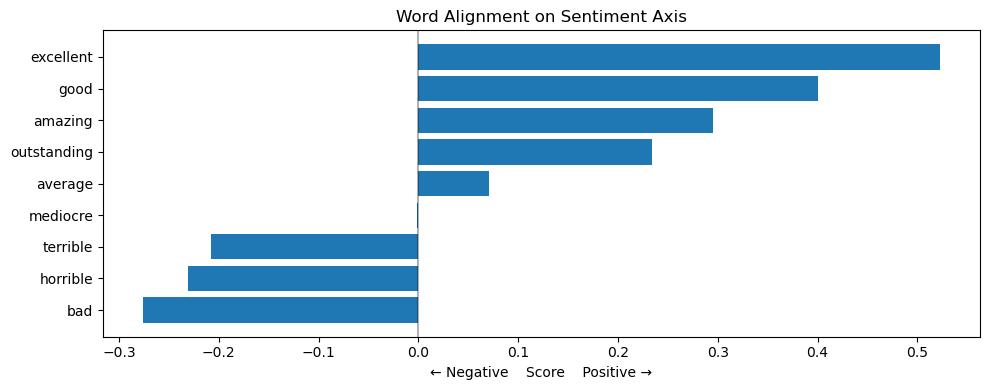

In [4]:
def plot_semantic_alignment(words, axis_vector, model, axis_name="Sentiment"):
    """Plot words along a semantic axis"""
    scores = [(word, get_word_score(word, axis_vector, model))
             for word in words]
    scores = sorted(scores, key=lambda x: x[1])

    words, values = zip(*scores)

    plt.figure(figsize=(10, 4))
    plt.barh(words, values)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Word Alignment on {axis_name} Axis')
    plt.xlabel(f'← Negative    Score    Positive →')
    plt.tight_layout()
    plt.show()

# Test with more words
test_words = ['excellent', 'terrible', 'amazing', 'horrible',
              'mediocre', 'outstanding', 'average', 'good', 'bad']
plot_semantic_alignment(test_words, sentiment_axis, model)

### Creating Robust Semantic Axes

Let's implement the expanded pole words approach for more reliable axes:

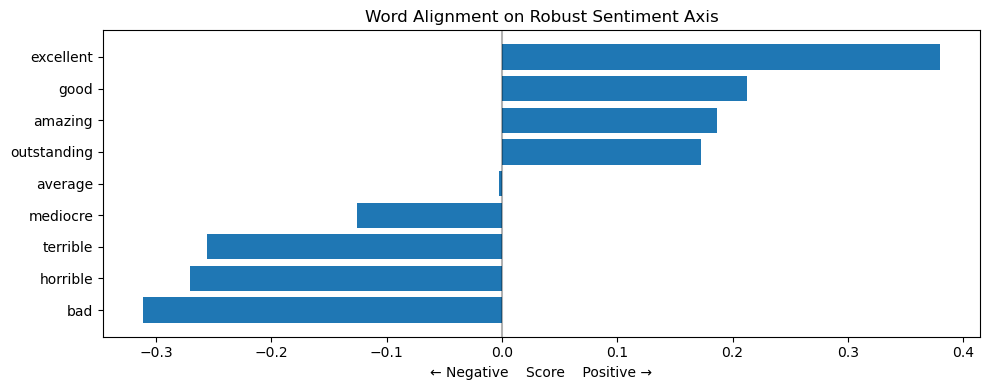

In [5]:
def create_robust_axis(pos_word, neg_word, model, k=5):
    """Create a semantic axis using expanded pole words"""
    # Get neighboring words for positive pole
    pos_neighbors = [word for word, _ in model.most_similar(pos_word, topn=k)]
    pos_neighbors.append(pos_word)

    # Get neighboring words for negative pole
    neg_neighbors = [word for word, _ in model.most_similar(neg_word, topn=k)]
    neg_neighbors.append(neg_word)

    # Calculate centroid vectors
    pos_centroid = np.mean([model[w] for w in pos_neighbors], axis=0)
    neg_centroid = np.mean([model[w] for w in neg_neighbors], axis=0)

    # Create axis vector
    return pos_centroid - neg_centroid

# Create a robust sentiment axis and compare results
robust_sentiment_axis = create_robust_axis('good', 'bad', model)
plot_semantic_alignment(test_words, robust_sentiment_axis, model,
                       "Robust Sentiment")

### Analyzing Words Along Multiple Axes

Finally, let's see how words position themselves in a 2D semantic space:

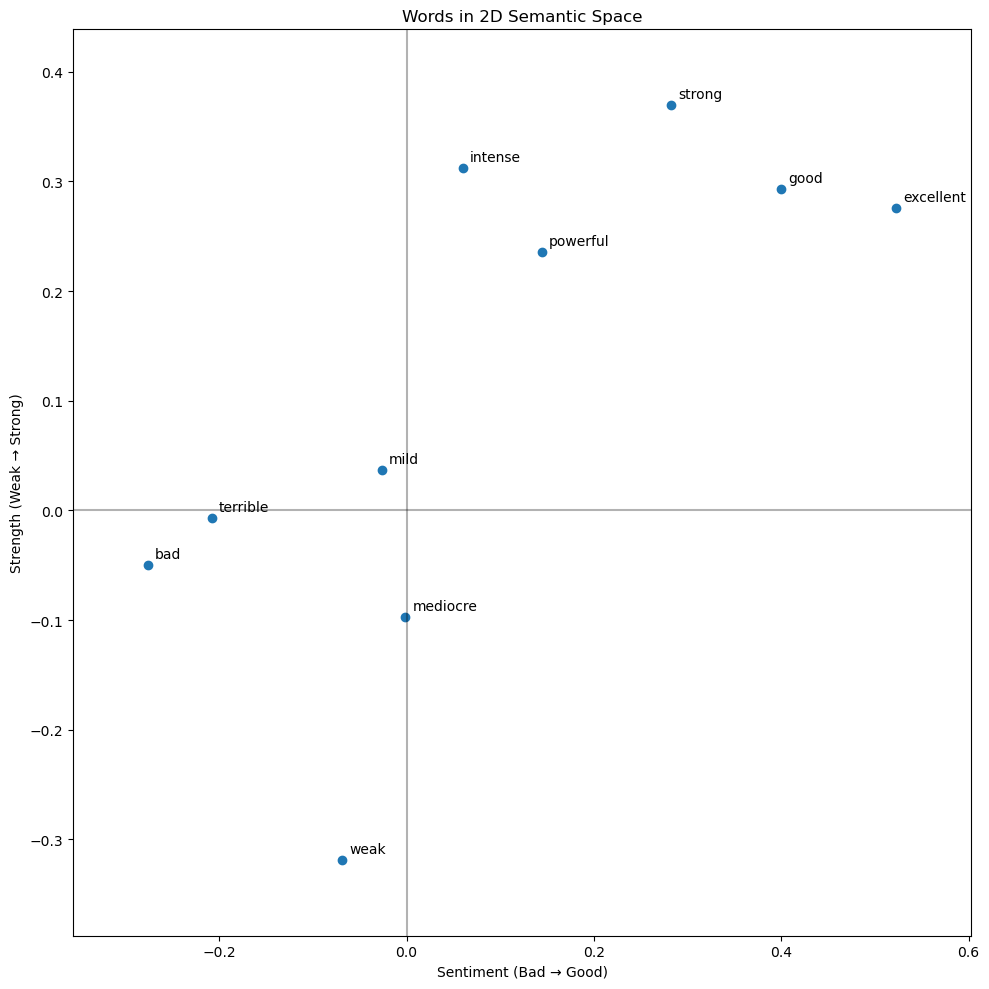

In [6]:
def plot_words_2d(words, axis1, axis2, model,
                  axis1_name="Axis 1", axis2_name="Axis 2"):
    """Plot words in 2D semantic space defined by two axes"""
    # Get scores for both axes
    scores_1 = [get_word_score(word, axis1, model) for word in words]
    scores_2 = [get_word_score(word, axis2, model) for word in words]

    plt.figure(figsize=(10, 10))
    plt.scatter(scores_1, scores_2, marker='o')

    # Add word labels with some padding
    for i, word in enumerate(words):
        plt.annotate(word, (scores_1[i], scores_2[i]),
                    xytext=(5, 5), textcoords='offset points')

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel(axis1_name)
    plt.ylabel(axis2_name)
    plt.title('Words in 2D Semantic Space')

    # Add some padding to the plot edges
    plt.margins(0.1)
    plt.tight_layout()
    plt.show()

# Create two different axes
sentiment_axis = create_semantic_axis('good', 'bad', model)
strength_axis = create_semantic_axis('strong', 'weak', model)

# Plot words in 2D semantic space
test_words = ['excellent', 'terrible', 'powerful', 'weak',
              'mediocre', 'strong', 'mild', 'intense', "bad", "good"]
plot_words_2d(test_words, sentiment_axis, strength_axis, model,
              "Sentiment (Bad → Good)", "Strength (Weak → Strong)")

### Exercise

When working with semantic axes:
- Test your axes with words that have known relationships to validate their behavior
- Consider using domain-specific word embeddings for specialized applications
- Compare results from regular and robust axes to ensure stability

```{footbibliography}
```